In [1]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17

In [3]:
import pandas as pd
import numpy as np

In [5]:
df = pd.read_csv('Data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1912 entries, 0 to 1911
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         1912 non-null   object 
 1   score         1912 non-null   int64  
 2   id            1912 non-null   object 
 3   subreddit     1912 non-null   object 
 4   url           1912 non-null   object 
 5   num_comments  1912 non-null   int64  
 6   body          1912 non-null   object 
 7   created       1912 non-null   float64
 8   Depressed     1912 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 134.6+ KB


In [6]:
df.Depressed.value_counts()

0    996
1    916
Name: Depressed, dtype: int64

In [17]:
import re
from nltk.corpus import stopwords
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['body'] = df['body'].apply(clean_text)
df['body'] = df['body'].str.replace('\d+', '')

In [18]:
df

,title,score,id,subreddit,url,num_comments,body,created,Depressed
0,Our most-broken and least-understood rules is ...,2323,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,175,understand people reply immediately op invitat...,1.572361e+09,1
1,"Regular Check-In Post, with important reminder...",672,m246c4,depression,https://www.reddit.com/r/depression/comments/m...,2584,welcome r depressions checkin post place take ...,1.615400e+09,1
2,Work is a perfect reason to commit suicide,628,oyqbtv,depression,https://www.reddit.com/r/depression/comments/o...,102,sucks majority life fucking thing planet want ...,1.628193e+09,1
3,anyone else at their lowest?,63,oyxdxb,depression,https://www.reddit.com/r/depression/comments/o...,20,past days rough new symptoms im depressed ove...,1.628216e+09,1
4,Im burned out.,22,oz056o,depression,https://www.reddit.com/r/depression/comments/o...,4,im fucking tired everything panic attack work ...,1.628227e+09,1
...,...,...,...,...,...,...,...,...,...
1907,What's something you do when noone is looking?,3,oz04n9,AskReddit,https://www.reddit.com/r/AskReddit/comments/oz...,12,whats something noone looking,1.628227e+09,0
1908,If you had to eat one type of canned food for ...,6,oyxjy0,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,23,eat one type canned food rest life choosing,1.628217e+09,0
1909,"People of Reddit, what do you think of virtue ...",4,oyypzt,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,people reddit think virtue signalling fau outr...,1.628221e+09,0
1910,Who or what do you trust the most?,6,oyuxy4,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,trust,1.628207e+09,0


In [24]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9333 unique tokens.


In [25]:
df

,title,score,id,subreddit,url,num_comments,body,created,Depressed
0,Our most-broken and least-understood rules is ...,2323,doqwow,depression,https://www.reddit.com/r/depression/comments/d...,175,understand people reply immediately op invitat...,1.572361e+09,1
1,"Regular Check-In Post, with important reminder...",672,m246c4,depression,https://www.reddit.com/r/depression/comments/m...,2584,welcome r depressions checkin post place take ...,1.615400e+09,1
2,Work is a perfect reason to commit suicide,628,oyqbtv,depression,https://www.reddit.com/r/depression/comments/o...,102,sucks majority life fucking thing planet want ...,1.628193e+09,1
3,anyone else at their lowest?,63,oyxdxb,depression,https://www.reddit.com/r/depression/comments/o...,20,past days rough new symptoms im depressed ove...,1.628216e+09,1
4,Im burned out.,22,oz056o,depression,https://www.reddit.com/r/depression/comments/o...,4,im fucking tired everything panic attack work ...,1.628227e+09,1
...,...,...,...,...,...,...,...,...,...
1907,What's something you do when noone is looking?,3,oz04n9,AskReddit,https://www.reddit.com/r/AskReddit/comments/oz...,12,whats something noone looking,1.628227e+09,0
1908,If you had to eat one type of canned food for ...,6,oyxjy0,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,23,eat one type canned food rest life choosing,1.628217e+09,0
1909,"People of Reddit, what do you think of virtue ...",4,oyypzt,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,people reddit think virtue signalling fau outr...,1.628221e+09,0
1910,Who or what do you trust the most?,6,oyuxy4,AskReddit,https://www.reddit.com/r/AskReddit/comments/oy...,24,trust,1.628207e+09,0


In [27]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1912, 250)


In [29]:
Y = pd.get_dummies(df['Depressed']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1912, 2)


In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1720, 250) (1720, 2)
(192, 250) (192, 2)


In [38]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/5
25/25 [==============================] - 36s 528ms/step - loss: 0.5680 - accuracy: 0.8210 - val_loss: 0.1092 - val_accuracy: 0.9709
Epoch 2/5
25/25 [==============================] - 12s 479ms/step - loss: 0.0711 - accuracy: 0.9808 - val_loss: 0.0463 - val_accuracy: 0.9767
Epoch 3/5
25/25 [==============================] - 12s 478ms/step - loss: 0.0288 - accuracy: 0.9897 - val_loss: 0.0257 - val_accuracy: 0.9942
Epoch 4/5
25/25 [==============================] - 12s 478ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 5/5
25/25 [==============================] - 12s 480ms/step - loss: 0.0078 - accuracy: 0.9993 - val_loss: 0.0242 - val_accuracy: 0.9884


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6/6 [==============================] - 1s 47ms/step - loss: 0.0432 - accuracy: 0.9844
Test set
  Loss: 0.043
  Accuracy: 0.984


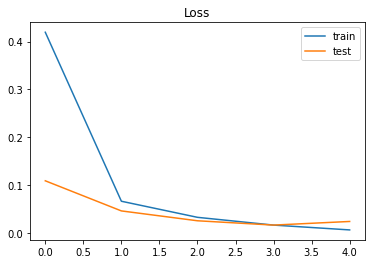

In [41]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

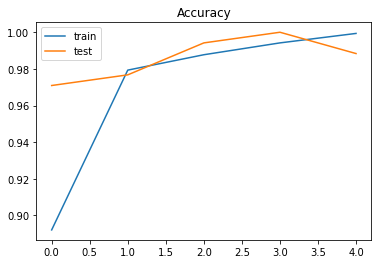

In [43]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();